In [8]:
# Load Libraries - Make sure to run this cell!
import pandas as pd
import numpy as np
import re
import datetime  
from collections import Counter
from sklearn import feature_extraction, tree, model_selection, metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib
from yellowbrick.classifier import ConfusionMatrix, ROCAUC
from yellowbrick.classifier import ClassificationReport
import scikitplot as skplt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

# Useful cyber libraries
import whois   # pip install python-whois
import tldextract  # pip install tldextract 
import ipaddress  # pip install ipaddress
import dns.query  # pip install dnspython
import dns.resolver
import entropy
from dns.exception import DNSException

<img src="../img/logo_white_bkg_small.png" align="right" />   


## Worksheet 5.2 Malicious URL Classification - Answers

This worksheet is a step-by-step guide on how to train a Machine Learning model that can detect malicious URLs. We will walk you through the process of transforming raw URL strings to Machine Learning features and creating a Decision Tree Classifer which you will use to determine whether a given URL is malicious or not. Once you have implemented the classifier, the worksheet will walk you through evaluating your model.  

### Overview 2 main steps:

1. **Feature Engineering** - from raw URL strings to features using [pandas](http://pandas.pydata.org/pandas-docs/stable/) DataFrame, datetime and [numpy](http://www.numpy.org/) manipulations.
2. **Machine Learning Classification** - predict whether a URL is malicious or not using a Decision Tree Classifier in [sklearn](http://scikit-learn.org/stable/) and evaluate model performance

We provide an additional notebook where you can see how to use "Featureless Deep Learning" to build such a classifier.


### Data

The dataset was build from various different open source data sources. Computationally intensive tasks such as retrieving the creation time for each unique domain in the data set via [whois](https://pypi.python.org/pypi/python-whois) have already been performed beforehand. Some of the open source URLs came with the zone apex only, others didn't include the protocol, therefore, we uniformly removed the protocol (http:// or https://) and subdomain (e.g. www) from the URL string if applicable.

Benign
- Custom automated webscraping of [Alexa Top 1M](https://blog.majestic.com/development/majestic-million-csv-daily/) with recursive depth of scraping of level 1.

Malicious
- Various blacklists
- [openphish](https://openphish.com/)
- [phishtank](https://www.phishtank.com/)
- [public GitHub faizann24](https://github.com/faizann24/Using-machine-learning-to-detect-malicious-URLs)
- some more sources

The dataset is perfectly balanced (50% benign and 50% malicious). We emphasized on getting benign URLs with paths and not just the domain. Furthermore, depending on your environment you can choose between a smaller subset (```url_data_small.csv``` containing 4000 URLs balanced) or the full data set (```url_data_full.csv``` containing 87380 URLs balanced).

In [9]:
## Load data
DATA_HOME = '../data/'
df = pd.read_csv(DATA_HOME + 'url_data_full.csv')
# df = pd.read_csv('../../Data/URL/url_data_small.csv')
df.isIP = df.isIP.astype(int)
print(df.shape)
df.sample(n=5) # print a random sample of the DataFrame

(87380, 5)


,url,isMalicious,domain,created,isIP
68804,pt-tkbi.com/documents/preview/onlinenow/web.php,1,pt-tkbi.com,2014-08-12 04:11:47.000,0
87032,vraert.com/wp-includes/pomo/src.php?id=,1,vraert.com,2005-08-01 00:00:00.000000,0
33957,google.com/+element14/posts,0,google.com,1997-09-15 00:00:00.000,0
11937,moz.com/local/overview,0,moz.com,1998-04-29 04:00:00.000,0
16795,nuxe.com/huile-prodigie-en-26/dry-oil-huile-pr...,0,nuxe.com,1998-02-27 00:00:00.000,0


#### Breakpoint: Load Features and Labels

If you got stuck in Part 1, please simply load the feature matrix we prepared for you, so you can move on to Part 2 and train a Decision Tree Classifier.

In [10]:
df_final = pd.read_csv(DATA_HOME + 'url_features_final_df.csv')
print(df_final.isMalicious.value_counts())
print(len(df_final.columns))
df_final.sample(n=5).head()

1    43690
0    43690
Name: isMalicious, dtype: int64
158


,isMalicious,isIP,Length,LengthDomain,DigitsCount,EntropyDomain,FirstDigitIndex,com,org,net,...,user,v,video,view,web,websc,wiki,wp,www,DurationCreated
38754,0,0,25,7,0,2.807355,0,1,0,0,...,0,0,0,0,0,0,0,0,0,8507
12549,0,0,38,14,0,3.093069,0,1,0,0,...,0,0,0,0,0,0,0,0,0,4877
87121,1,0,60,20,0,3.746439,0,1,0,0,...,0,0,0,0,0,0,0,0,0,444
5048,0,0,28,12,6,3.418296,22,1,0,0,...,0,0,0,0,0,0,0,0,0,6660
38250,0,0,47,11,18,3.027169,30,1,0,0,...,0,0,0,0,0,0,0,0,0,6497


## Part 2 - Machine Learning

To learn simple classification procedures using [sklearn](http://scikit-learn.org/stable/) we have split the work flow into 5 steps.

### Step 1: Prepare Feature matrix ```X``` and ```target``` vector containing the URL labels

- X is the feature matrix
- target is a vector containing the labels for each URL (often also called *y* in statistics)
- for sklearn input X and target can either be a pandas DataFrame/Series or numpy array/vector respectively (can't be lists!)

Tasks:
- assign ```'isMalicious'``` column to a pandas Series named 'target'
- drop ```'isMalicious'``` column from DataFrame and name the resulting pandas DataFrame ```X```
- save the column names of the ```X``` in a variable called ```feature_names```

In [11]:
target = df_final['isMalicious']
X = df_final.drop(['isMalicious'], axis=1)
print('Final features', X.columns)
feature_names = list(X.columns)
print(len(feature_names))

# also valid, convert directly to numpy array
#target = np.array(target)  # 1d array of default type int64! for classification
#X = np.array(X)  # nd-array of default type float64

Final features Index(['isIP', 'Length', 'LengthDomain', 'DigitsCount', 'EntropyDomain',
       'FirstDigitIndex', 'com', 'org', 'net', 'ru',
       ...
       'user', 'v', 'video', 'view', 'web', 'websc', 'wiki', 'wp', 'www',
       'DurationCreated'],
      dtype='object', length=157)
157


In [12]:
X.sample(5)

,isIP,Length,LengthDomain,DigitsCount,EntropyDomain,FirstDigitIndex,com,org,net,ru,...,user,v,video,view,web,websc,wiki,wp,www,DurationCreated
48397,0,74,13,0,3.392747,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,601
54369,0,29,16,0,3.577820,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2662
61042,0,33,13,3,3.180833,15,1,0,0,0,...,0,0,0,0,0,0,0,0,0,999
52312,0,141,17,24,3.572469,44,1,0,0,0,...,1,0,0,0,0,0,0,0,0,3294
81739,0,62,17,3,3.454822,26,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1081


In [13]:
X.sample(5)

,isIP,Length,LengthDomain,DigitsCount,EntropyDomain,FirstDigitIndex,com,org,net,ru,...,user,v,video,view,web,websc,wiki,wp,www,DurationCreated
82398,0,147,11,38,3.095795,84,1,0,0,0,...,0,0,0,0,0,1,0,0,1,7618
32623,0,123,10,18,2.921928,33,1,0,0,0,...,0,0,0,0,0,0,0,0,0,8597
34360,0,36,10,0,3.121928,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3712
59547,0,87,17,23,3.337175,46,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1714
62157,0,20,14,0,3.378783,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,567


In [14]:
target.sample(5)

58401    1
20083    0
58135    1
17808    0
15406    0
Name: isMalicious, dtype: int64

### Step 2: Simple Cross-Validation

Tasks:
- split your feature matrix X and target vector into train and test subsets using sklearn [model_selection.train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Sklearn documentation uses also ```X``` to represent the feature matrix of shape [n_samples, n_features], but ```y``` to represent the labels, which we call ```target``` here of shape [n_samples] or [n_samples, n_outputs].

In [20]:
# Simple Cross-Validation: Split the data set into training and test data
X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=0.25)

### Step 3: Train the model and make a prediction

Finally, we have prepared and segmented the data. Let's start classifying!!   

Tasks:

-  Use the sklearn [tree.DecisionTreeClassfier()](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), create a decision tree with standard parameters, and train it using the ```.fit()``` function with ```X_train``` and ```target_train``` data.
-  Next, pull a random row from the ```X_test``` array and ```target_test``` vector and see if your classifier got it correct by using the ```.predict()``` function on your classifier with ```test_feature``` as input to this method. When you extract only one random row from the numpy array you'll have to apply ```.reshape(1, -1)``` before passing it into the ```.predict()``` method.

If you are interested in trying a real unknown domain, you'll have to create a function to generate the features for that domain before you run it through the classifier (see function ```is_malicious``` a few cells below). 

In [21]:
# Train the decision tree based on the entropy criterion
clf = tree.DecisionTreeClassifier()  # clf means classifier
clf = clf.fit(X_train, target_train)

# Extract a row from the test data
i_row = 70
test_feature = X_test.iloc[i_row]
test_target = target_test.iloc[i_row]

# Make the prediction
#pred = clf.predict(test_feature.reshape(1, -1))
pred = clf.predict(test_feature.values.reshape(1, -1))
print('Predicted class:', pred)
print('Accurate prediction?', pred[0] == test_target)

Predicted class: [0]
Accurate prediction? True


In [22]:
clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [23]:
# Additional helper functions for is_malicious function
def ip_matcher(address):
    # Used to validate if string is an ipaddress, currently only IPv4 supported
    ip = re.match(
        '^(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)$', address)
    if ip:
        return 1
    else:
        return 0

def strip_http(s):
    pattern = re.compile('(http[s]?://)')
    clean_url = pattern.sub('', s)
    
    try:
        if clean_url[-1] in ['/']:
            clean_url = clean_url[:-1]
        if tldextract.extract(clean_url).subdomain:
            clean_url = re.sub(tldextract.extract(clean_url).subdomain + '.', '', clean_url)
    except:
        pass
    return clean_url

In [24]:
# Load database of creation dates of various unqiue domains from our data set

domains_created_db = pd.read_csv(DATA_HOME + 'domains_created_db.csv')
domains_created_db.created = pd.to_datetime(domains_created_db.created, errors='coerce')
domains_created_db.head()


,url,created
0,01453.com,2000-02-14 00:00:00
1,netsolhost.com,2004-09-21 00:00:00
2,032255.com,2014-08-08 10:58:27
3,05minute.com,2004-05-21 00:00:00
4,blogspot.com,2000-07-31 00:00:00


In [25]:
# Load Vectorizer models from part 1
from six.moves import cPickle as pickle

# Note all functions for feature calcuations need to be again available here to make new predictions on new URLs

def custom_path_tokenizer(path):  # input one path from one URL
    return list(filter(None, re.compile('[\?\=/\._-]').split(path.lower()))) 

def extract_path(url):
    return re.sub('.'.join([tldextract.extract(url).domain, tldextract.extract(url).suffix]), '', url)

def H_entropy (x):
    # Calculate Shannon Entropy
    return entropy.shannon_entropy(x)

def firstDigitIndex( s ):
    for i, c in enumerate(s):
        if c.isdigit():
            return i + 1
    return 0

models = ["feature_names","CountVectorizer_tlds","CountVectorizer_domains","CountVectorizer_paths"]

tmp_models = []
for key in models:

    with open(DATA_HOME + key + '.pickle', 'rb') as f:
            tmp_models.append(pickle.load(f))
        
feature_names = tmp_models[0]
CountVectorizer_tlds = tmp_models[1]
CountVectorizer_domains = tmp_models[2]
CountVectorizer_paths = tmp_models[3]

In [26]:
def is_malicious(url, clf, feature_names, domains_created_db, CountVectorizer_tlds, CountVectorizer_domains, CountVectorizer_paths):
    """
    INPUT:
    - new raw URL string
    - trained model/classifiers 'clf'
    - feature_names to correctly identify index in numpy array
    - domains_created_db: custom database (from .csv file) containing creation date of unique domains of our data set
    - trained model CountVectorizer_tlds
    - trained model CountVectorizer_domains
    - trained model CountVectorizer_paths
    
    OUTPUT:
    - binary prediction (int 0 or 1, where 1 means URL is most likely to be malicious)
    
    """
    
    # clean raw URL
    url = strip_http(url)  # make sure strip_http function is available

    # extract portions of URL and retrieve create date from database
    domain = tldextract.extract(url).domain
    tld = tldextract.extract(url).suffix
    path = extract_path(url)  # make sure extract_path function is available
    created = domains_created_db.created[domains_created_db.url == '.'.join([domain, tld])]

    try:
        delta = (pd.to_datetime(datetime.date.today()) - created).dt.days.values[0]
    except:
        delta = 0
    
    # initialize numpy array
    n_features = len(feature_names)
    url_features = np.empty(shape=(1, n_features))
    
    # lexical features simple
    url_features[0, feature_names.index('Length')] = len(url)
    url_features[0, feature_names.index('LengthDomain')] = len(domain)
    pattern = re.compile('([0-9])')
    url_features[0, feature_names.index('DigitsCount')] = len(re.findall(pattern, url))
    url_features[0, feature_names.index('EntropyDomain')] = H_entropy(domain)  # make sure H_entropy function is available
    url_features[0, feature_names.index('FirstDigitIndex')] = firstDigitIndex(url)  # make sure firstDigitIndex function is available
   
    # lexical features bag-of-words
    new_row_tlds = CountVectorizer_tlds.transform([tld]).toarray()
    start = feature_names.index(CountVectorizer_tlds.get_feature_names()[0])
    stop = feature_names.index(CountVectorizer_tlds.get_feature_names()[-1])                            
    url_features[0, start:stop+1] = new_row_tlds
    
    new_row_domains = CountVectorizer_domains.transform([domain]).toarray()
    start = feature_names.index(CountVectorizer_domains.get_feature_names()[0])
    stop = feature_names.index(CountVectorizer_domains.get_feature_names()[-1])                            
    url_features[0, start:stop+1] = new_row_domains
    
    new_row_paths = CountVectorizer_paths.transform([path]).toarray()
    start = feature_names.index(CountVectorizer_paths.get_feature_names()[0])
    stop = feature_names.index(CountVectorizer_paths.get_feature_names()[-1])                            
    url_features[0, start:stop+1] = new_row_paths
    
    # host-based features
    url_features[0, feature_names.index('DurationCreated')] = delta
    url_features[0, feature_names.index('isIP')] = ip_matcher(url)
    
    pred = clf.predict(url_features)
    return pred[0]


test_URL = 'https://www.google.com'

print('Prediction of domain %s\nis %s [0 means \"benign\" and 1 \"is malicious\"]: ' \
%(test_URL, is_malicious(test_URL, clf, feature_names, domains_created_db, CountVectorizer_tlds,\
                         CountVectorizer_domains, CountVectorizer_paths)))  

# print('\nTiming result of new prediction:\n')
# result = %timeit -o is_malicious(test_URL, clf, feature_names, domains_created_db, CountVectorizer_tlds,\
#                          CountVectorizer_domains, CountVectorizer_paths)

Prediction of domain https://www.google.com
is 1 [0 means "benign" and 1 "is malicious"]: 


In [28]:
#Try it yourself
test_URL = "facebook3423423434234234.com"
is_malicious(test_URL, clf, feature_names, domains_created_db, CountVectorizer_tlds, CountVectorizer_domains, CountVectorizer_paths)

1

### Step 4: Assess model accuracy with simple cross-validation

Tasks:
- Use sklearn [metrics.accuracy_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) to determine your models accuracy. Detailed Instruction:
    - Use your trained model to predict the labels of your test data ```X_test```. Run ```.predict()``` method on the clf with your test data ```X_test``` and store the results in a variable called ```target_pred```.. 
    - Then calculate the accuracy using ```target_test``` (which are the true labels/groundtruth) AND your models predictions on the test portion ```target_pred``` as inputs (in that order ```target_test, target_pred```). The advantage here is to see how your model performs on new data it has not been seen during the training phase.
    
- Finally print out the confusion matrix using [metrics.confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

In [46]:
# fair approach: make prediction on test data portion
target_pred = clf.predict(X_test)
print(metrics.accuracy_score(target_test, target_pred))
print('Confusion Matrix\n', metrics.confusion_matrix(target_test, target_pred))

0.898970016021973
Confusion Matrix
 [[9842 1115]
 [1092 9796]]


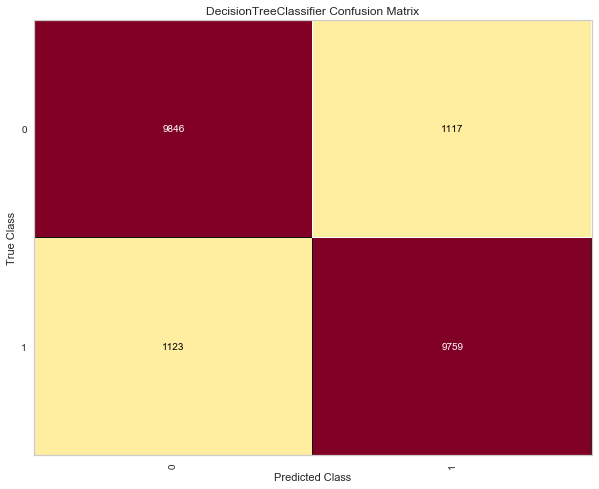

In [43]:
cm = ConfusionMatrix(clf, classes=[0,1])

#Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
#cm.fit(X_train, target_train)

#To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
#and then creates the confusion_matrix from scikit learn.
cm.score(X_test, target_test)

#How did we do?
cm.poof()

In [44]:
# Classification Report...neat summary
print(metrics.classification_report(target_test, target_pred, target_names=['Not Malicious', 'Malicious']))

               precision    recall  f1-score   support

Not Malicious       0.90      0.90      0.90     10963
    Malicious       0.90      0.90      0.90     10882

    micro avg       0.90      0.90      0.90     21845
    macro avg       0.90      0.90      0.90     21845
 weighted avg       0.90      0.90      0.90     21845



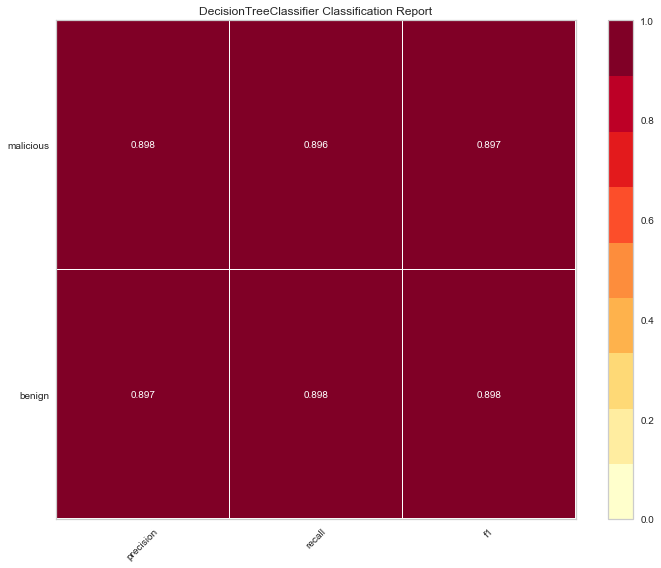

In [45]:
visualizer = ClassificationReport(clf, classes=['benign', 'malicious'])

visualizer.fit(X_train, target_train)  # Fit the training data to the visualizer
visualizer.score(X_test, target_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

In [46]:
# short-cut
clf.score(X_test, target_test)

0.8974593728542001

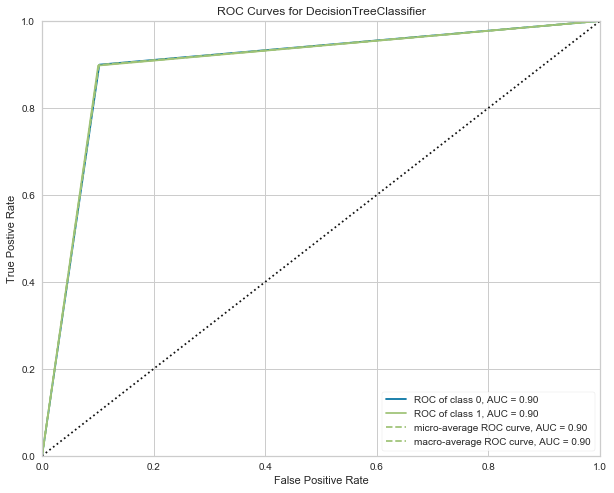

In [47]:
visualizer = ROCAUC(clf)

visualizer.fit(X_train, target_train)  # Fit the training data to the visualizer
visualizer.score(X_test, target_test)  # Evaluate the model on the test data 
g = visualizer.poof()  

### Step 5: Assess model accuracy with k-fold cross-validation

Tasks:
- Partition the dataset into *k* different subsets
- Create *k* different models by training on *k-1* subsets and testing on the remaining subsets
- Measure the performance on each of the models and take the average measure.

*Short-Cut*
All of these steps can be easily achieved by simply using sklearn's [model_selection.KFold()](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) and [model_selection.cross_val_score()](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) functions.

In [48]:
scores = model_selection.cross_val_score(clf, X, target, cv=3)
print(scores)

[0.89309256 0.89229554 0.89349722]


In [49]:
# Get avergage score +- Standard Error (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.sem.html)
from scipy.stats import sem
def mean_score( scores ):
    return "Mean score: {0:.3f} (+/- {1:.3f})".format( np.mean(scores), sem( scores ))
print( mean_score( scores))

Mean score: 0.893 (+/- 0.000)


### Step 6: Get the best predictors

Tasks:
- Using your fitted clf (here DecisionTreeClassifier) get the attribute [feature\_importances\_](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
- Create a new df ```f_imp``` with the column names of your features (not including isMalicious column of original df) and transpose ```f_imp```.
- Sort [pd.sort\_vaues](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html) the new df ```f_imp```.

In [50]:
f_imp = pd.DataFrame([clf.feature_importances_, feature_names]).T.sort_values(0, ascending=False)
f_imp.head(20)

,0,1
156,0.456788,DurationCreated
1,0.0737138,Length
130,0.0582343,php
4,0.0494417,EntropyDomain
2,0.0420171,LengthDomain
5,0.0394767,FirstDigitIndex
3,0.0357997,DigitsCount
154,0.0187264,wp
109,0.0142471,html
119,0.0111797,login


## Visualizing Feature Importances
You can also visualize feature importances 

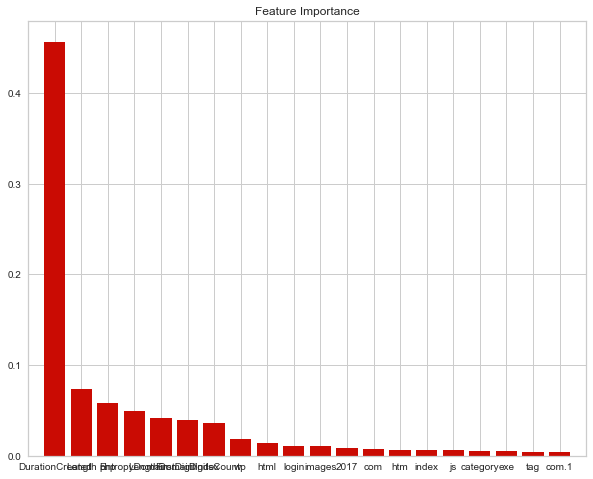

In [51]:
skplt.estimators.plot_feature_importances(clf, feature_names=feature_names)
plt.show()

#### (Optional) Visualizing your Tree
As an optional step, you can actually visualize your tree.  The following code will generate a graph of your decision tree.  You will need graphviz (http://www.graphviz.org) and pydotplus (or pydot) installed for this to work.
The Griffon VM has this installed already, but if you try this on a Mac, or Linux machine you will need to install graphviz.

In [ ]:
# These libraries are used to visualize the decision tree and require that you have GraphViz
# and pydot or pydotplus installed on your computer.

from sklearn.externals.six import StringIO  
from IPython.core.display import Image
import pydotplus as pydot


dot_data = StringIO() 
tree.export_graphviz(clf, out_file=dot_data, 
                     feature_names=feature_names,
                    filled=True, rounded=True,  
                    special_characters=True) 

graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())